In [1]:
import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np


CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import (FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, 
                                             CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, 
                                             WATER_MATERIAL, HEAVY_WATER_MATERIAL, BERYLLIUM_MATERIAL, 
                                             BORATED_STEEL_MATERIAL)
from src.utils.pre_processing.pre_processing import (plot_geometry)
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS


In [2]:

material = openmc.Materials([FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, WATER_MATERIAL, HEAVY_WATER_MATERIAL, BERYLLIUM_MATERIAL, BORATED_STEEL_MATERIAL])
material.export_to_xml()

In [3]:
r_pin_fuel = openmc.ZCylinder(r=1.)
pin_fuel_fuel_cell = openmc.Cell(fill=FUEL_MATERIAL, region=-r_pin_fuel)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+r_pin_fuel)
pin_fuel_universe = openmc.Universe(cells=(pin_fuel_fuel_cell, graphite_cell))

pin_helium_cell = openmc.ZCylinder(r=1.)
helium_cell = openmc.Cell(fill=HELIUM_MATERIAL, region=-pin_helium_cell)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+pin_helium_cell)
pin_helium_universe = openmc.Universe(cells=(helium_cell, graphite_cell))

all_graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL)
outer_universe = openmc.Universe(cells=(all_graphite_cell,))

lat_he_fuel = openmc.HexLattice()
lat_he_fuel.center = (0., 0.)
lat_he_fuel.pitch = (4.5,)   # pitch en cm
lat_he_fuel.outer = outer_universe

lat_he_fuel.universes = [
    [pin_helium_universe, pin_fuel_universe] * 12, # 5th ring
    [pin_helium_universe, pin_fuel_universe] * 9,    # 4th ring    
    [pin_helium_universe, pin_fuel_universe] * 6,        # 3rd ring
    [pin_helium_universe, pin_fuel_universe] * 3,     # 2nd ring
    [pin_fuel_universe]          # 1st ring
]   

outer_surface = openmc.ZCylinder(r=22.)
height_top_active_part = openmc.ZPlane(z0=250.0)
height_bottom_active_part = openmc.ZPlane(z0=-250.0)


In [ ]:
# Main cell: lattice inside graphite cylinder
graphite_cell = openmc.Cell(
    fill=lat_he_fuel,
    region=(-outer_surface & -height_top_active_part & +height_bottom_active_part)
)

hw_region = -openmc.ZCylinder(r=45.) & ~graphite_cell.region
hw_cell = openmc.Cell(fill=HEAVY_WATER_MATERIAL, region=hw_region)

bloc_universe = openmc.Universe(cells=(graphite_cell, hw_cell))

# Create a lattice of graphite universes
graphite_lattice = openmc.HexLattice()
graphite_lattice.center = (0., 0.)
graphite_lattice.pitch = (55.0,)  # pitch in cm
graphite_lattice.outer = bloc_universe
graphite_lattice.universes = [
    [bloc_universe]*6,                # center (1 universe)
    [bloc_universe]               # first ring (6 universes)
]# Create the outer cell with a vacuum boundary condition


graphite_assembly_cell = openmc.Cell(
    fill=graphite_lattice,
    region=(-openmc.model.HexagonalPrism(edge_length=194.0, orientation='y', origin=(0.0, 0.0))
 & -height_top_active_part & +height_bottom_active_part)
)


beryllium_above_assembly_cell = openmc.Cell(
    fill=BERYLLIUM_MATERIAL,
    region=(-openmc.model.HexagonalPrism(edge_length=194.0, orientation='y', origin=(0.0, 0.0))
 & ~graphite_assembly_cell.region & -openmc.ZPlane(z0=280.0) & +openmc.ZPlane(z0=250.0)) 
)

beryllium_below_assembly_cell = openmc.Cell(
    fill=BERYLLIUM_MATERIAL,
    region=(-openmc.model.HexagonalPrism(edge_length=194.0, orientation='y', origin=(0.0, 0.0))
 & ~graphite_assembly_cell.region & +openmc.ZPlane(z0=-280.0) & -openmc.ZPlane(z0=-250.0))
)

steel_liner_cell = openmc.Cell(
    fill=BORATED_STEEL_MATERIAL,
    region=(-openmc.model.HexagonalPrism(edge_length=200.0, orientation='y', origin=(0.0, 0.0))
 & ~graphite_assembly_cell.region & ~beryllium_above_assembly_cell.region &  ~beryllium_below_assembly_cell.region
 & -openmc.ZPlane(z0=290.0) & +openmc.ZPlane(z0=-290.0)) 
 )

outer_sphere = openmc.Sphere(r=1000.0, boundary_type='vacuum')

air_region = -outer_sphere & ~steel_liner_cell.region
air_cell = openmc.Cell(fill=AIR_MATERIAL, region=air_region)

geometry = openmc.Geometry([steel_liner_cell, graphite_assembly_cell, 
                            beryllium_above_assembly_cell, beryllium_below_assembly_cell,
                            air_cell])

geometry.export_to_xml()


 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 1
Plot file: plot_openmc_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:  400  400
Coloring: Materials
Basis: XY
Pixels: 600 600

 Processing plot 1: plot_openmc_xy.png...


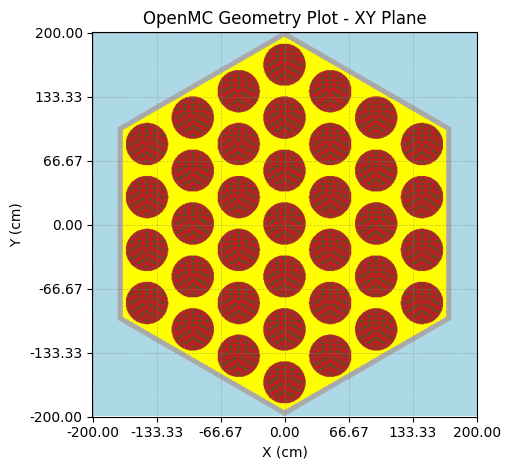

In [5]:

plot_geometry(materials = material, plane="xy", width=400, height=400, dpi=500)


 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 2
Plot file: plot_openmc_yz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:  600  600
Coloring: Materials
Basis: YZ
Pixels: 600 600

 Processing plot 2: plot_openmc_yz.png...


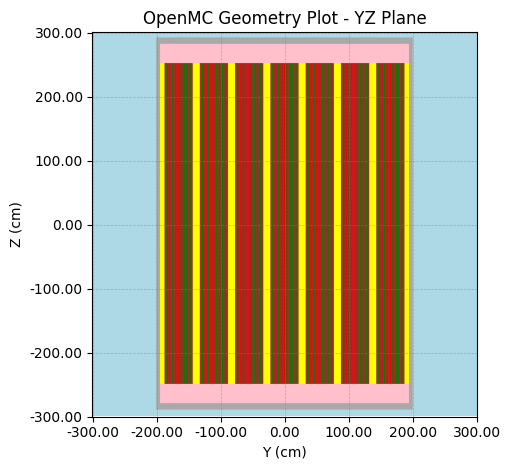

In [6]:
plot_geometry(materials = material, plane="yz", width=600, height=600)

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 3
Plot file: plot_openmc_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:   50   50
Coloring: Materials
Basis: XY
Pixels: 600 600

 Processing plot 3: plot_openmc_xy.png...


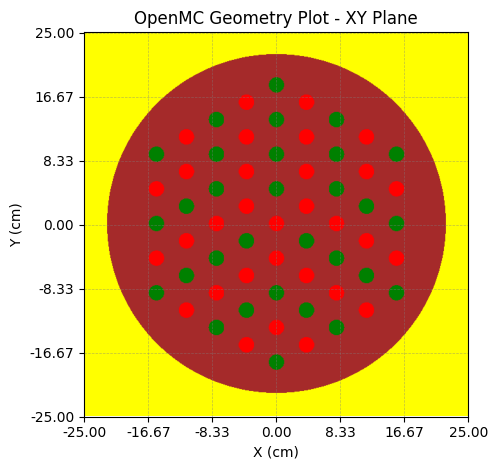

In [7]:
plot_geometry(materials = material, plane="xy", width=50, height=50)
